In [1]:
import vcg
import tools
import perturb_ecg
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import tqdm

In [2]:
fs = 1024

t,y = tools.default_vcg_solve(60, fs=fs, duration=10)

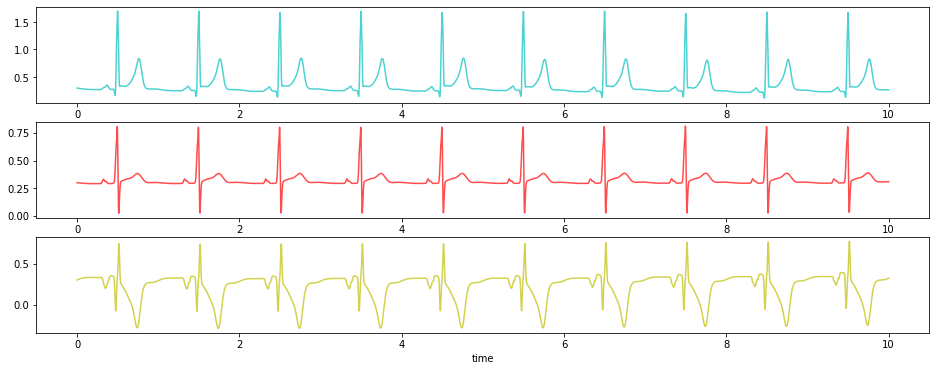

In [3]:
fig, axs = plt.subplots(3,1, figsize=[16,6])
axs[0].plot(t,y[:,0], 'c', alpha=0.7)
axs[1].plot(t,y[:,1], 'r', alpha=0.7)
axs[2].plot(t,y[:,2], 'y', alpha=0.7)

for ax in axs :
    ax.set_xlabel('time')

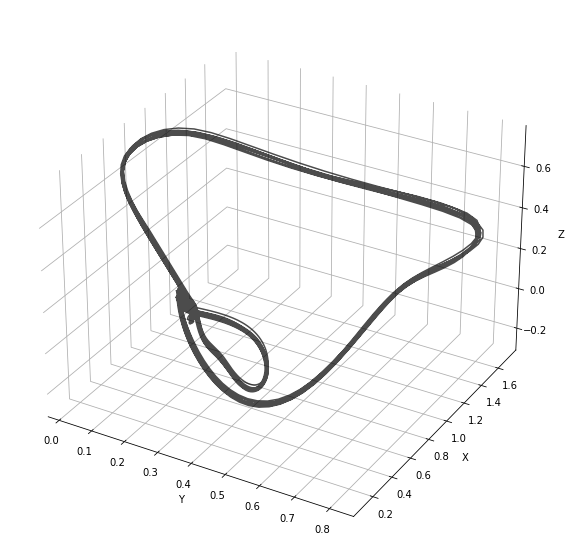

In [4]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes(projection='3d')
ax.plot3D(y[:,1], y[:,0], y[:,2], 'k', alpha=0.7)
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.grid(True);
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w');

In [5]:
e = tools.convert_vcg_to_12lead(y)

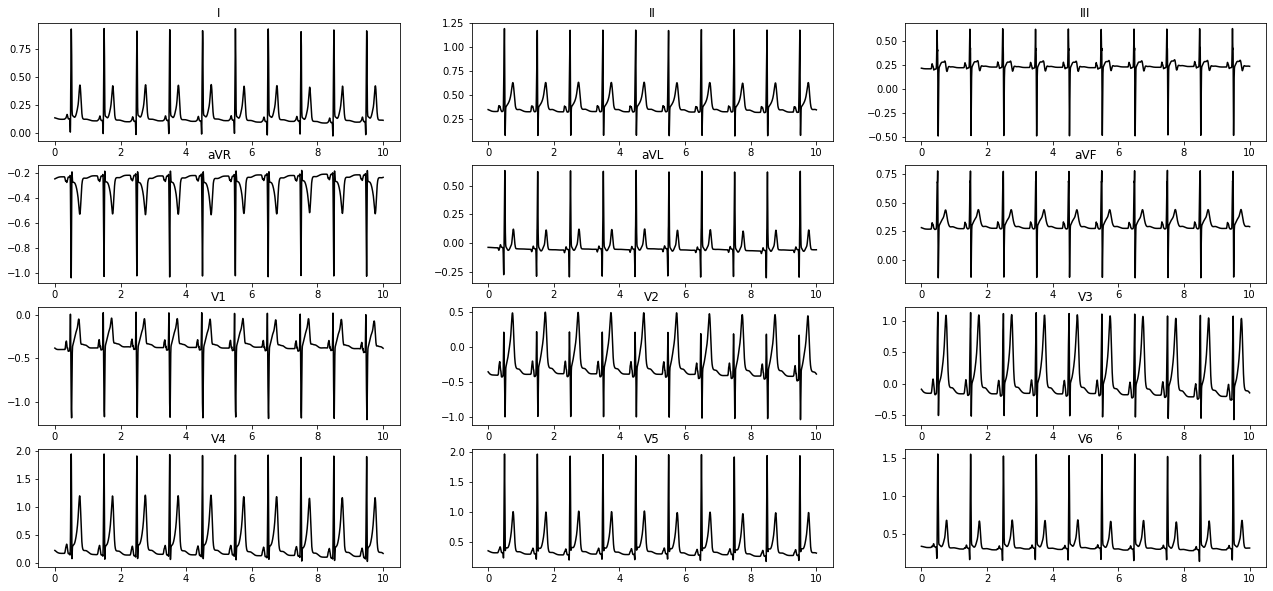

In [6]:
fig, axs = plt.subplots(4,3, figsize=[22,10])

axs_f = axs.flatten()

idx = 0
for lead in tools.Dower_lead_map :
    
    axs_f[idx].plot(t, e[:,tools.Dower_lead_map[lead]], 'k')
    axs_f[idx].set_title(lead)
    #axs_f[idx].set_xlabel('time (s)')
    
    idx += 1

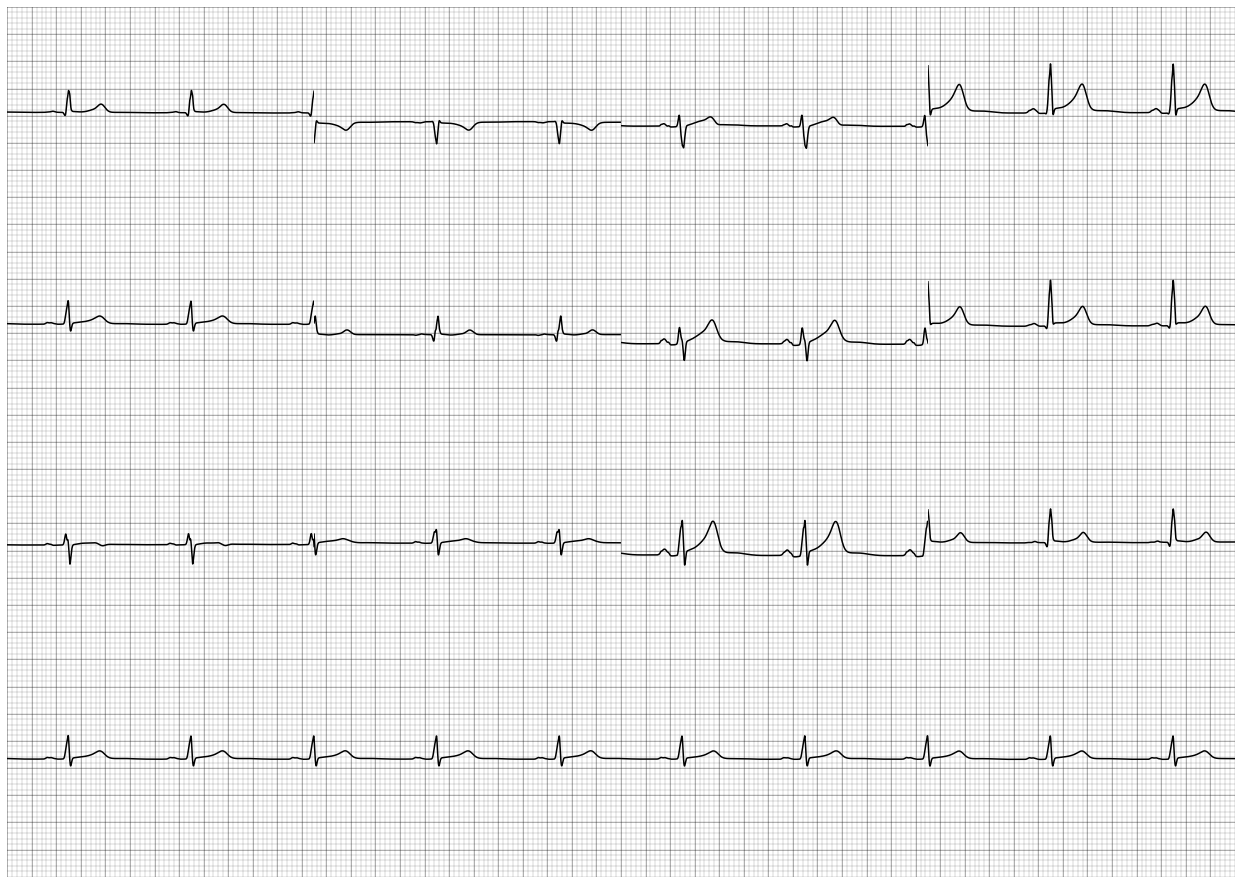

In [7]:
tools.plot12(e, fs=fs, n_squares=8)

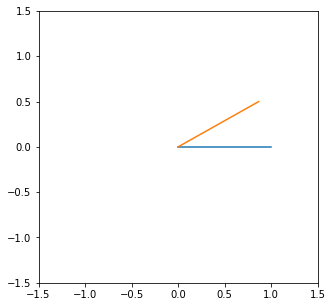

In [8]:
# rotation

plt.figure(figsize=[5,5])
v1 = np.array([1,0,0])
plt.plot([0,v1[0]], [0,v1[1]])
v2 = tools.Rz(30) @ v1
plt.plot([0,v2[0]], [0,v2[1]])
plt.axis([-1.5,1.5,-1.5,1.5]);

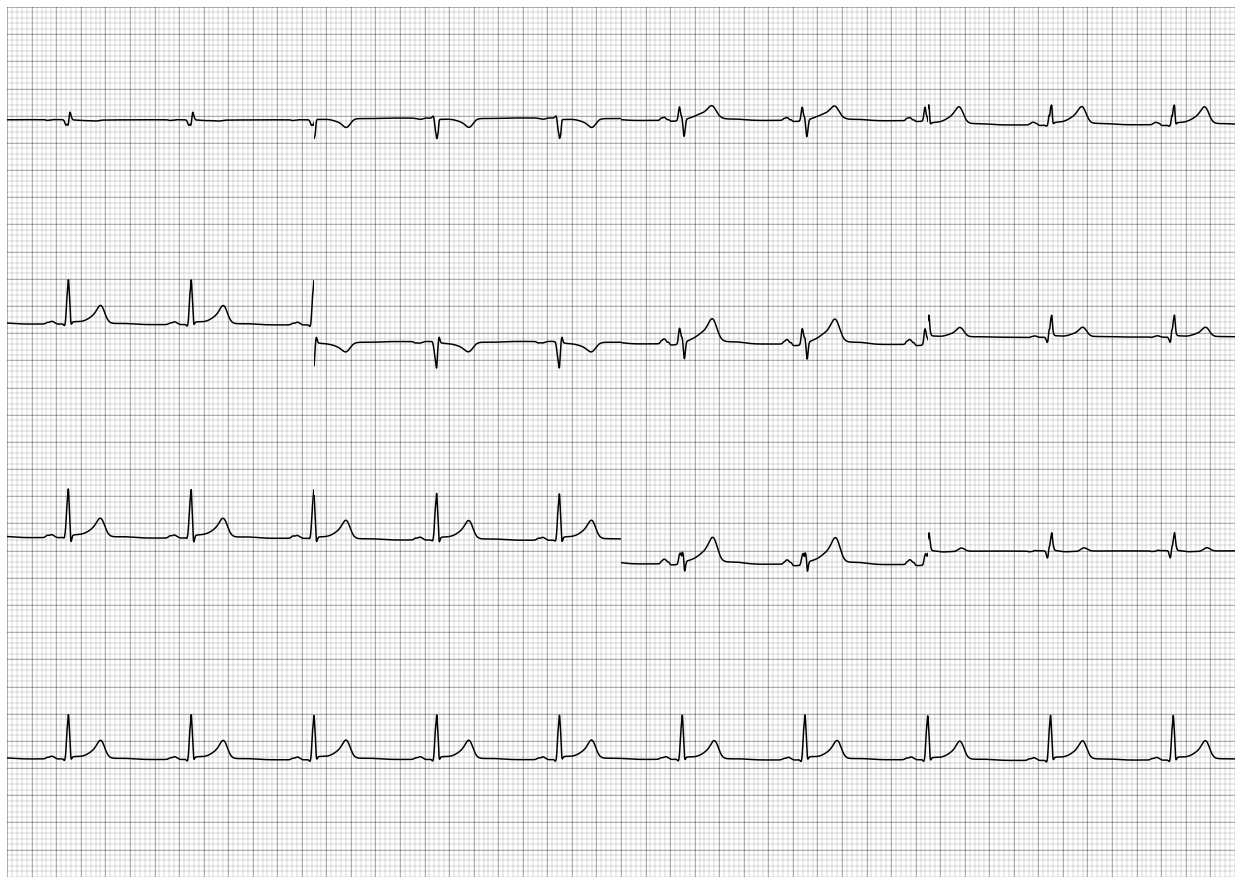

In [9]:
vcg_rotate = tools.rotate_vcg(y, th_z=60)
ecg_rotate = tools.convert_vcg_to_12lead(vcg_rotate)
tools.plot12(ecg_rotate, fs=1024)

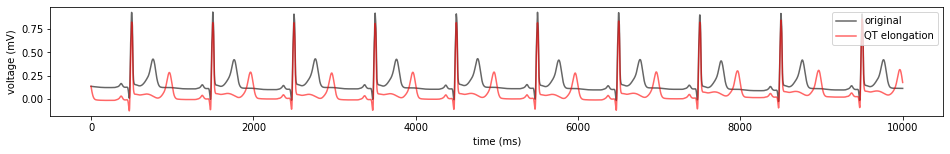

In [10]:
# QT elongation

vcg_ode = vcg.VCG(60)

t1, y1 = tools.solve_vcg_object(vcg_ode, duration=10)

vcg_ode2 = perturb_ecg.qt_elongation(vcg_ode, ms_forward=200)

t2, y2 = tools.solve_vcg_object(vcg_ode2, duration=10)

del vcg_ode
del vcg_ode2

e1 = tools.convert_vcg_to_12lead(y1)
e2 = tools.convert_vcg_to_12lead(y2)

plt.figure(figsize=[16,2])
plt.plot(t1*1000, e1[:,0], 'k', alpha=0.6, label='original')
plt.plot(t2*1000, e2[:,0], 'r', alpha=0.6, label='QT elongation')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)');
plt.legend();

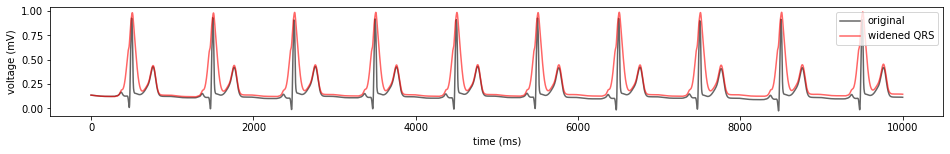

In [11]:
# wide QRS

vcg_ode = vcg.VCG(60)

t1, y1 = tools.solve_vcg_object(vcg_ode, duration=10)

vcg_ode2 = perturb_ecg.wide_qrs(vcg_ode, percent_widened=800, scaledown=0.5)

t2, y2 = tools.solve_vcg_object(vcg_ode2, duration=10)

del vcg_ode
del vcg_ode2

e1 = tools.convert_vcg_to_12lead(y1)
e2 = tools.convert_vcg_to_12lead(y2)

plt.figure(figsize=[16,2])
plt.plot(t1*1000, e1[:,0], 'k', alpha=0.6, label='original')
plt.plot(t2*1000, e2[:,0], 'r', alpha=0.6, label='widened QRS')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)');
plt.legend();

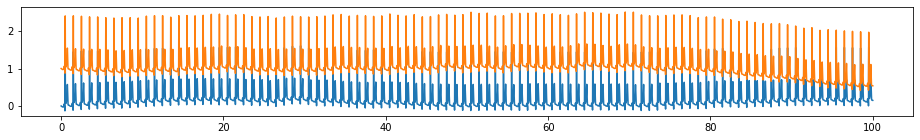

In [12]:
# do initial conditions matter?
# Yes

vcg_ode = vcg.VCG(60)
v0 = np.array([0,0,0,0])
t1, y1 = tools.solve_vcg_object(vcg_ode, v0=v0, duration=100)

vcg_ode = vcg.VCG(60)
v0 = np.array([0,1,1,1])
t2, y2 = tools.solve_vcg_object(vcg_ode, v0=v0, duration=100)

plt.figure(figsize=[16,2])
plt.plot(t1, y1[:,0])
plt.plot(t2, y2[:,0])

In [13]:
# developing the noise tool...

out = perturb_ecg.band_limited_noise([512*10,12], .1, 100)
out2 = perturb_ecg.band_limited_noise([512*10,12], 10, 100)

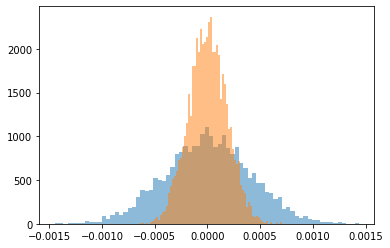

In [14]:
plt.hist(out[:,0], bins=int(np.sqrt(5120)), alpha=0.5, density=True);
plt.hist(out2[:,0], bins=int(np.sqrt(5120)), alpha=0.5, density=True);

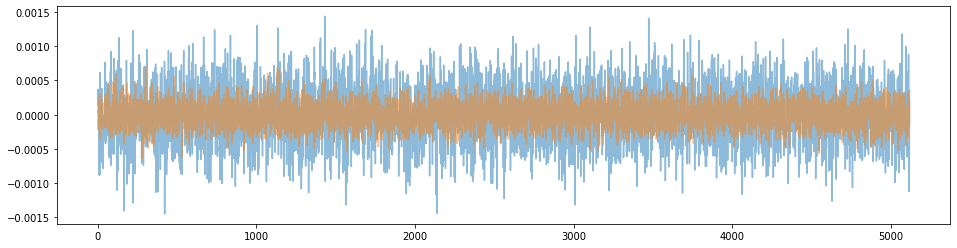

In [15]:
plt.figure(figsize=[16,4])
plt.plot(out[:,0], alpha=0.5)
plt.plot(out2[:,0], alpha=0.5)

In [16]:
high_amps = []

for i in range(10) :
    out = perturb_ecg.band_limited_noise([512*10,12], .1, 10 + i*10)
    
    high_amps.append(np.mean(np.sort(np.abs(out[:,0])[-512:])))

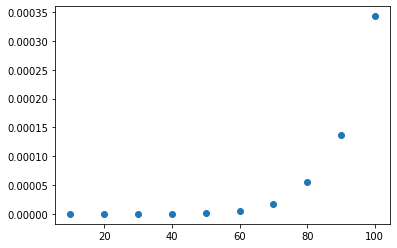

In [17]:
plt.figure()

plt.plot([10+i*10 for i in range(10)], high_amps, 'o')

In [18]:
np.mean(out, axis=0)

array([ 1.06724757e-06,  5.90328947e-06, -1.60282909e-05, -2.68837678e-04,
       -1.26782458e-03, -3.47627369e-03, -6.22336058e-03, -7.18728987e-03,
       -4.31062493e-03,  9.58807306e-04,  3.75434110e-03,  1.17058102e-03])

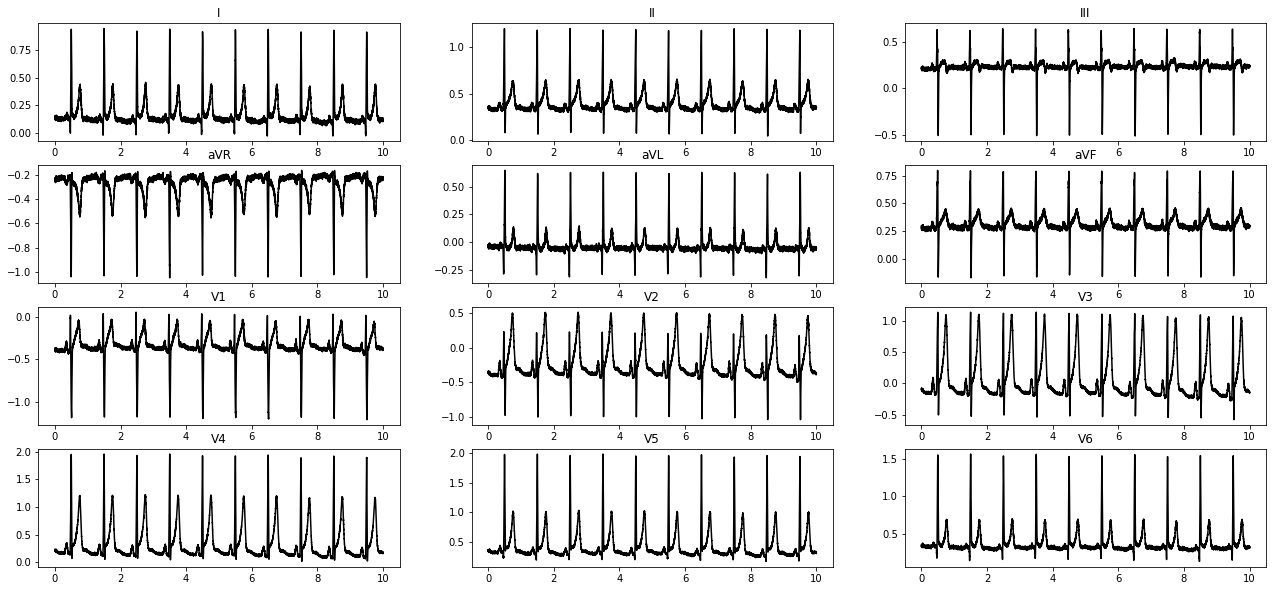

In [19]:
# starting with a fresh, simple ecg
t,y = tools.default_vcg_solve(60, fs=fs, duration=10)
e = tools.convert_vcg_to_12lead(y)

e_noisy = perturb_ecg.add_noise(e, 50, 60, .01, fs=fs)

fig, axs = plt.subplots(4,3, figsize=[22,10])

axs_f = axs.flatten()

idx = 0
for lead in tools.Dower_lead_map :
    
    axs_f[idx].plot(t, e_noisy[:,tools.Dower_lead_map[lead]], 'k')
    axs_f[idx].set_title(lead)
    #axs_f[idx].set_xlabel('time (s)')
    
    idx += 1

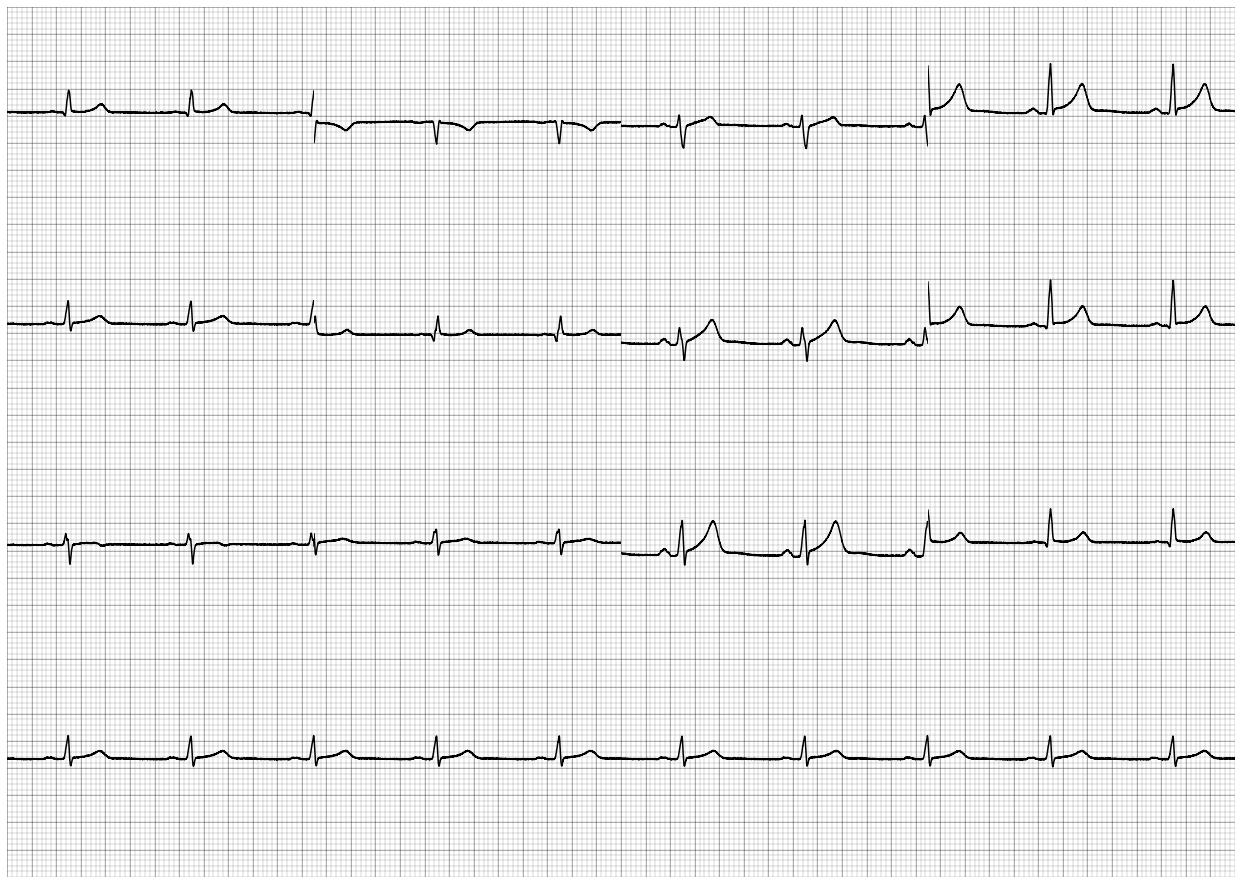

In [20]:
tools.plot12(e_noisy, fs=fs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:22<00:00,  7.11it/s]

(161, 5000, 12)


Text(0.5, 1.0, 'Lead II - HR perturbation')

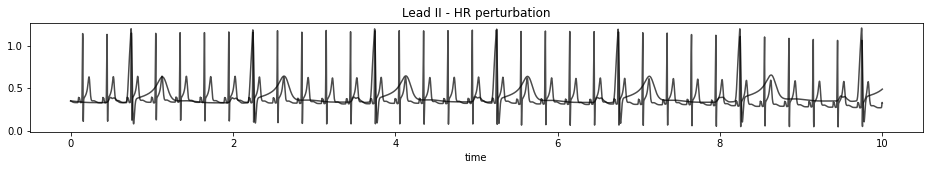

In [62]:
# HR perturbation

HR_range = np.linspace(40, 200, 161)

all_ecgs = []

vcg_first = vcg.VCG(HR_range[0])
t, y = tools.solve_vcg_object(vcg_first, fs=500)
e = tools.convert_vcg_to_12lead(y)

all_ecgs.append(e)

for hr in tqdm.tqdm(HR_range[1:]) :
    vcg_new = perturb_ecg.change_HR(vcg_first, hr)
    t, y = tools.solve_vcg_object(vcg_new, fs=500)
    e = tools.convert_vcg_to_12lead(y)

    all_ecgs.append(e)
    
    del vcg_new
    
e_arr = np.array(all_ecgs)
print(e_arr.shape)

plt.figure(figsize=[16,2])
plt.plot(t, e_arr[0,:,1].T, 'k', alpha=0.7);
plt.plot(t, e_arr[-1,:,1].T, 'k', alpha=0.7);

plt.xlabel('time')
plt.title('Lead II - HR perturbation')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.58it/s]

(161, 5000, 12)


Text(0.5, 1.0, 'Lead II - QT elongation')

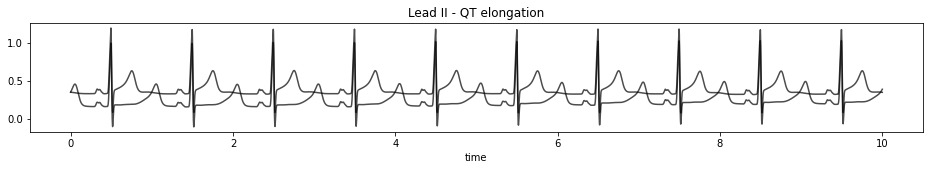

In [51]:
# t wave delay

t_push_range = np.linspace(0, 300, 31)

all_ecgs_qt = []

vcg_first = vcg.VCG(60)
t, y = tools.solve_vcg_object(vcg_first, fs=500)
e = tools.convert_vcg_to_12lead(y)

all_ecgs_qt.append(e)

for ms_f in tqdm.tqdm(t_push_range[1:]) :
    vcg_new = perturb_ecg.qt_elongation(vcg_first, ms_forward=ms_f)
    t, y = tools.solve_vcg_object(vcg_new, fs=500)
    e = tools.convert_vcg_to_12lead(y)

    all_ecgs_qt.append(e)
    
    del vcg_new
    
e_arr_qt = np.array(all_ecgs_qt)
print(e_arr.shape)

plt.figure(figsize=[16,2])
plt.plot(t, e_arr_qt[0,:,1].T, 'k', alpha=0.7);
plt.plot(t, e_arr_qt[-1,:,1].T, 'k', alpha=0.7);

plt.xlabel('time')
plt.title('Lead II - QT elongation')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.35it/s]

(51, 5000, 12)


Text(0.5, 1.0, 'Lead II - Widened QRS')

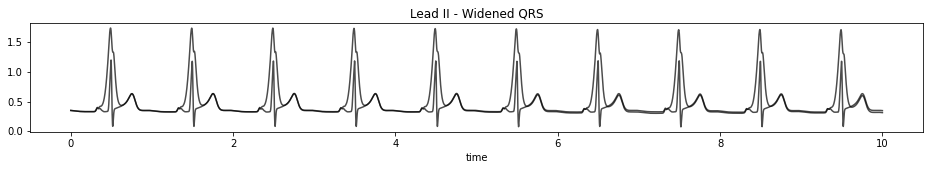

In [52]:
# now, for QRS complex width

pw_range = np.linspace(0, 500, 51)

all_ecgs_qrs = []

vcg_first = vcg.VCG(60)
t, y = tools.solve_vcg_object(vcg_first, fs=500)
e = tools.convert_vcg_to_12lead(y)

all_ecgs_qrs.append(e)

for pw in tqdm.tqdm(pw_range[1:]) :
    vcg_new = perturb_ecg.wide_qrs(vcg_first, percent_widened=pw)
    t, y = tools.solve_vcg_object(vcg_new, fs=500)
    e = tools.convert_vcg_to_12lead(y)

    all_ecgs_qrs.append(e)
    
    del vcg_new
    
e_arr_qrs = np.array(all_ecgs_qrs)
print(e_arr_qrs.shape)

plt.figure(figsize=[16,2])
plt.plot(t, e_arr_qrs[0,:,1].T, 'k', alpha=0.7);
plt.plot(t, e_arr_qrs[-1,:,1].T, 'k', alpha=0.7);

plt.xlabel('time')
plt.title('Lead II - Widened QRS')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.99it/s]

(51, 5000, 12)


Text(0.5, 1.0, 'Lead II - Widened QRS')

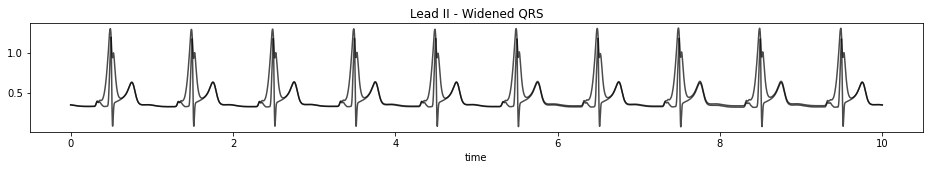

In [24]:
# for widened QRS, we need to adjust scale of the QRS complex a bit

e_arr_qrs_max = np.max(e_arr_qrs[:,:,1], axis=1)

scale_factor = e_arr_qrs_max[0]/e_arr_qrs_max

all_ecgs_qrs = []

vcg_first = vcg.VCG(60)
t, y = tools.solve_vcg_object(vcg_first, fs=500)
e = tools.convert_vcg_to_12lead(y)

all_ecgs_qrs.append(e)

i = 1
for pw in tqdm.tqdm(pw_range[1:]) :
    vcg_new = perturb_ecg.wide_qrs(vcg_first, percent_widened=pw, scaledown=scale_factor[i])
    t, y = tools.solve_vcg_object(vcg_new, fs=500)
    e = tools.convert_vcg_to_12lead(y)

    all_ecgs_qrs.append(e)
    
    i += 1
    
    del vcg_new
    
e_arr_qrs = np.array(all_ecgs_qrs)
print(e_arr_qrs.shape)

plt.figure(figsize=[16,2])
plt.plot(t, e_arr_qrs[0,:,1].T, 'k', alpha=0.7);
plt.plot(t, e_arr_qrs[-1,:,1].T, 'k', alpha=0.7);

plt.xlabel('time')
plt.title('Lead II - Widened QRS')

In [25]:
# load RHCnet
import sys
sys.path.append('../RHCNet/')
sys.path.append('../RHCNet/Utils/')
sys.path.append('../RHCNet/Models/')
sys.path.append('../RHCNet/SavedModels/')


from network_tools import make_final_net

RHCNet = make_final_net(pre_trained_loc='../RHCNet/SavedModels/ecg_supervised_416.h5', 
                        model_loc='../RHCNet/SavedModels/trained_model/best_val_weights.pkl')

Metal device set to: Apple M1


2022-05-25 10:46:15.708374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-25 10:46:15.708835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [53]:
# normalize HR ECGs

all_ecgs_norm = []

for e in all_ecgs :
    e -= np.mean(e, axis=0)
    e /= np.std(e, axis=0)
    
    all_ecgs_norm.append(e)
    
all_ecgs_norm = np.array(all_ecgs_norm)

In [54]:
p = RHCNet(all_ecgs_norm)
p_noise = RHCNet(perturb_ecg.add_noise(all_ecgs_norm, 50, 60, .05, fs=500))

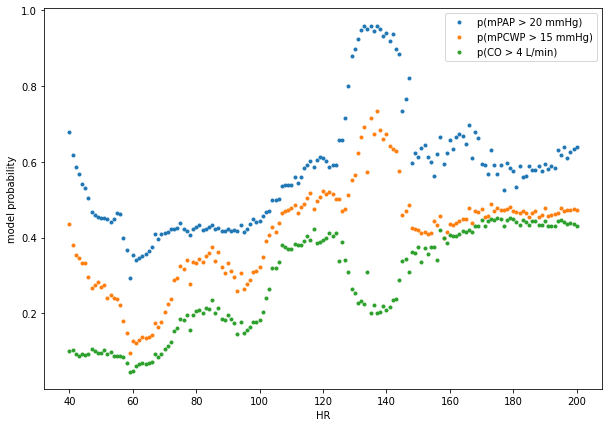

In [55]:
plt.figure(figsize=[10,7])
plt.plot(HR_range, p[:,0], '.', label='p(mPAP > 20 mmHg)')
plt.plot(HR_range, p[:,1], '.', label='p(mPCWP > 15 mmHg)')
plt.plot(HR_range, p[:,2], '.', label='p(CO > 4 L/min)')
plt.legend();
plt.xlabel('HR');
plt.ylabel('model probability');

Text(0, 0.5, '')

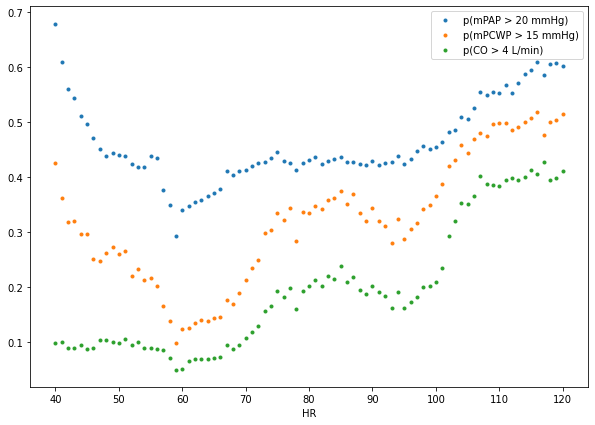

In [29]:
plt.figure(figsize=[10,7])
plt.plot(HR_range, p_noise[:,0], '.', label='p(mPAP > 20 mmHg)')
plt.plot(HR_range, p_noise[:,1], '.', label='p(mPCWP > 15 mmHg)')
plt.plot(HR_range, p_noise[:,2], '.', label='p(CO > 4 L/min)')
plt.legend();
plt.xlabel('HR');
plt.ylabel('')

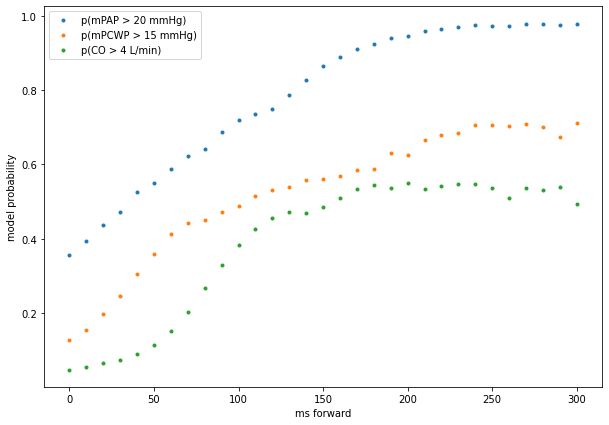

In [30]:
# normalize QT ECGs

all_ecgs_norm = []

for e in all_ecgs_qt :
    e -= np.mean(e, axis=0)
    e /= np.std(e, axis=0)
    
    all_ecgs_norm.append(e)
    
all_ecgs_norm = np.array(all_ecgs_norm)

p = RHCNet(all_ecgs_norm)
p_noise = RHCNet(perturb_ecg.add_noise(all_ecgs_norm, 50, 60, .05, fs=500))

plt.figure(figsize=[10,7])
plt.plot(t_push_range, p[:,0], '.', label='p(mPAP > 20 mmHg)')
plt.plot(t_push_range, p[:,1], '.', label='p(mPCWP > 15 mmHg)')
plt.plot(t_push_range, p[:,2], '.', label='p(CO > 4 L/min)')
plt.legend();
plt.xlabel('ms forward');
plt.ylabel('model probability');

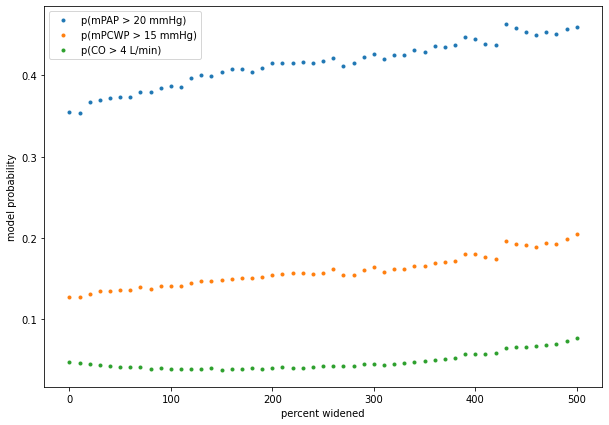

In [31]:
# normalize QRS ECGs

all_ecgs_norm = []

for e in all_ecgs_qrs :
    e -= np.mean(e, axis=0)
    e /= np.std(e, axis=0)
    
    all_ecgs_norm.append(e)
    
all_ecgs_norm = np.array(all_ecgs_norm)

p = RHCNet(all_ecgs_norm)
p_noise = RHCNet(perturb_ecg.add_noise(all_ecgs_norm, 50, 60, .05, fs=500))

plt.figure(figsize=[10,7])
plt.plot(pw_range, p[:,0], '.', label='p(mPAP > 20 mmHg)')
plt.plot(pw_range, p[:,1], '.', label='p(mPCWP > 15 mmHg)')
plt.plot(pw_range, p[:,2], '.', label='p(CO > 4 L/min)')
plt.legend();
plt.xlabel('percent widened');
plt.ylabel('model probability');

In [60]:
import vcg

n_vcgs = 20

new_vcg_list = []
out_list = []

for v in range(n_vcgs) :
    vcg_new = perturb_ecg.modify_parameters(vcg.VCG(60))
    new_vcg_list.append(vcg_new)
    out_list.append(tools.solve_vcg_object(vcg_new, fs=500)[1])
    
    
    
all_all_ecgs = []
HR_range = np.linspace(40, 120, 81)
for vcg_i in new_vcg_list :

    all_ecgs = []

    vcg_first = vcg_i
    t, y = tools.solve_vcg_object(vcg_first, fs=500)
    e = tools.convert_vcg_to_12lead(y)

    all_ecgs.append(e)

    for hr in tqdm.tqdm(HR_range[1:]) :
        vcg_new = perturb_ecg.change_HR(vcg_first, hr)
        t, y = tools.solve_vcg_object(vcg_new, fs=500)
        e = tools.convert_vcg_to_12lead(y)

        all_ecgs.append(e)

        del vcg_new

    e_arr = np.array(all_ecgs)
    
    all_all_ecgs.append(e_arr)

 42%|███████████████████████████████████████████████████▍                                                                     | 34/80 [00:02<00:03, 13.53it/s]


KeyboardInterrupt: 

In [43]:
all_out = []

for e in all_all_ecgs :
    all_out.append(RHCNet(e))

Text(0, 0.5, 'model probability')

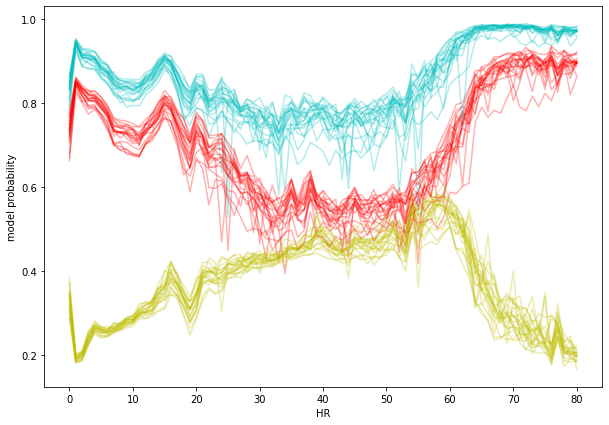

In [49]:
plt.figure(figsize=[10,7])

for out in all_out :
    plt.plot(out[:,0], 'c', alpha=0.3)
    plt.plot(out[:,1], 'r', alpha=0.3)
    plt.plot(out[:,2], 'y', alpha=0.3)
    
plt.xlabel('HR')
plt.ylabel('model probability')

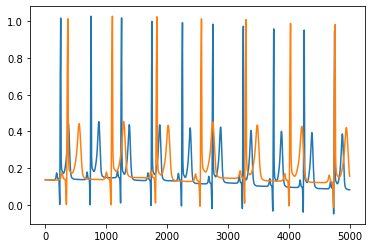

In [61]:
plt.plot(all_ecgs[0][:,0])
plt.plot(all_ecgs[1][:,0])